In [1]:
import numpy as np

import pandas as pd
import holidays

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import linear_model as lm
from datetime import datetime
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler


In [7]:
file_path_receipts = '../data/cash_receipts.csv'
receipts_df = pd.read_csv(file_path_receipts)
file_path_weather = '../data/weather.csv' #I got this from a website called https://openweathermap.org/
weather_df = pd.read_csv(file_path_weather)

In [8]:
receipts_df

,Receipt ID,Date,Time,User,Description,Amount,Is Refund,Is Voided
0,1000005.009,"Apr 11, 18",2:06 PM,"Keller, Edie",$4.00,4.0,0,0
1,1000006.009,"May 4, 18",10:36 AM,"Keller, Edie","$1,890.00",1890.0,0,0
2,1000007.009,"May 10, 18",12:11 PM,"Dempsey, Stacey",**Voided**,0.0,0,1
3,1000008.009,"May 10, 18",12:13 PM,"Dempsey, Stacey",**Voided**,0.0,0,1
4,1000009.009,"May 10, 18",12:19 PM,"Dempsey, Stacey",**Voided**,0.0,0,1
...,...,...,...,...,...,...,...,...
41307,3000005.009,"Apr 12, 18",12:57 PM,"Keller, Edie",Journal Entry,30.0,0,0
41308,3000006.009,"May 4, 18",10:30 AM,"Keller, Edie",Journal Entry,1890.0,0,0
41309,3000007.009,"May 4, 18",11:24 AM,"Keller, Edie",Journal Entry,51.0,0,0
41310,3000060.009,"Jun 26, 18",4:10 PM,"Keller, Edie",Journal Entry,1890.0,0,0


## Lets try and pull out all the data we need out of these two dataframes, and then get rid of all the bad or useless rows.

In [7]:
receipts_dt = receipts_df.copy()
receipts_dt['Time'] = pd.to_datetime(receipts_dt['Time'], format='%I:%M %p').dt.hour
receipts_dt['Date'] = pd.to_datetime(receipts_dt['Date'], format='%b %d, %y')

#Our data was in the wrong timezone so let's convert it.
weather_df['dt_iso'] = pd.to_datetime(weather_df['dt_iso'], format='%Y-%m-%d %H:%M:%S %z UTC')
weather_df['dt_iso'] = weather_df['dt_iso'].dt.tz_convert('America/Los_Angeles')
pattern  = r"(\d*\-\d*\-\d\d)"
weather_df['Date'] = weather_df['dt_iso'].dt.strftime('%Y-%m-%d')

# We have a lot of info for each day so lets take info from 11 - 7 pm, then make date column back to datetime object.
weather_df['Time'] = weather_df['dt_iso'].dt.strftime('%H').astype('int')
weather_df = weather_df[(weather_df['Time'] >= 11) & (weather_df['Time'] <= 19)]
weather_df['Date'] = pd.to_datetime(weather_df['Date'])

# Now we can select only specific columns, the important ones out of weather.csv.
weather_needed = weather_df[['Date', 'Time', 'temp', 'weather_description', 'wind_speed', 'wind_gust']]

weather_top = weather_needed.drop(columns = 'Time').groupby('Date').agg(
                max_temp=('temp', 'max'),
                weather=('weather_description', lambda subdf: subdf.iloc[0]),
                max_wind=('wind_speed', 'max'))

# Now we need to get our receitps data frame to a column with the date, and amount total amount made.
# We have a lot of voided and refunded receipts, so we should get rid of all of these receipts, and any receipt with the same receipt ID since that means it was later refunded or voided. 
clean_receipts_df = receipts_dt.groupby('Receipt ID').filter(lambda subdf: subdf['Is Voided'].sum() == 0 and subdf['Is Refund'].sum() == 0)

# We also have some that are just Journal Entries so let's drop those too. I found the one User that Added all but one of these so we can just drop those.
# We have one extra transaction under Journal Entry by one Use Owen, Rachel. We just need to drop this transaction and the one attached to it. 
# After some eploration there was no attached transaction! So we can now just drop the last journal entry row.
us_holidays = holidays.UnitedStates(years=range(2018, 2026))

best_receipts_df = clean_receipts_df[~(clean_receipts_df['User']== 'Keller, Edie') & ~(clean_receipts_df['Description']== 'Journal Entry')].copy()
best_receipts_df['Day'] = best_receipts_df['Date'].dt.weekday
best_receipts_df['Is Weekday'] = (best_receipts_df['Date'].dt.weekday < 5).astype(int)
best_receipts_df['Is Holiday'] = best_receipts_df['Date'].isin(us_holidays)

# Filtering times based on weekend or weekday and holiday
holiday_filter = (best_receipts_df['Is Holiday'] == 1)
weekday_filter = (best_receipts_df['Is Weekday'] == 1)
weekend_filter = (best_receipts_df['Is Weekday'] == 0)

weekend_holiday_time = (best_receipts_df['Time'] >= 12) & (best_receipts_df['Time'] < 18)

weekday_time = (best_receipts_df['Time'] >= 14) & (best_receipts_df['Time'] < 18)

weekend_or_holiday_time = holiday_filter | weekend_filter & weekend_holiday_time
weekday_time = weekday_filter & weekday_time
final_filter = weekend_or_holiday_time | weekday_time

time_filtered = best_receipts_df[final_filter]
time_filtered


/var/folders/f1/wss5j8sx5cvcrhqr458pnxv00000gn/T/ipykernel_37433/4040147841.py:36: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  best_receipts_df['Is Holiday'] = best_receipts_df['Date'].isin(us_holidays)


,Receipt ID,Date,Time,User,Description,Amount,Is Refund,Is Voided,Day,Is Weekday,Is Holiday
10,1000015.009,2018-05-19,12,"Ruzich, Rachel",$27.00,27.00,0,0,5,0,False
11,1000016.009,2018-05-19,12,"Perez, Taylor",$16.00,16.00,0,0,5,0,False
12,1000017.009,2018-05-19,12,"Ruzich, Rachel",$27.00,27.00,0,0,5,0,False
13,1000018.009,2018-05-19,12,"Perez, Taylor",$16.00,16.00,0,0,5,0,False
14,1000019.009,2018-05-19,12,"Ruzich, Rachel",$9.00,9.00,0,0,5,0,False
...,...,...,...,...,...,...,...,...,...,...,...
41301,1052602.009,2025-07-26,16,"Smith, Abigail",$18.50,18.50,0,0,5,0,False
41302,1052603.009,2025-07-26,16,"Smith, Abigail",$27.75,27.75,0,0,5,0,False
41303,1052604.009,2025-07-26,16,"Smith, Abigail",$18.50,18.50,0,0,5,0,False
41304,1052605.009,2025-07-26,16,"Smith, Abigail",$18.50,18.50,0,0,5,0,False


## Let's Map each day to the day of the week for OHE Later.

In [8]:
day_map = {0: 'Monday', 1: 'Tuesday', 2: 'Wednesday', 3: 'Thursday', 4: 'Friday', 5: 'Saturday', 6: 'Sunday'}
best_receipts_day_mapped = best_receipts_df.copy()
best_receipts_day_mapped['Day'] = best_receipts_df['Day'].map(day_map)

## Now our tables are looking extremely good and almost exactly what we want, our next option is to either join the tables now, or we can groupby Date on best_receipts_df first and make a new table with the date and total money made.

In [9]:
dollars_made = best_receipts_day_mapped.groupby('Date').agg(dollars_made=('Amount', 'sum'),
                                                    is_weekday=('Is Weekday', lambda subdf: subdf.iloc[0]),
                                                    day=('Day', lambda subdf: subdf.iloc[0]), 
                                                    holiday=('Is Holiday', lambda subdf: subdf.iloc[0]))
                                                    

## Add a month column for OHE later and check if its in season.

In [10]:
dollars_made = dollars_made.reset_index()
dollars_full_date = dollars_made.copy()
after_may15 = ((dollars_full_date['Date'].dt.month == 5) & (dollars_full_date['Date'].dt.day > 15)) | (dollars_full_date['Date'].dt.month > 5)
before_sep1 = (dollars_full_date['Date'].dt.month < 9)
is_in_range = after_may15 & before_sep1
during_season = dollars_full_date[is_in_range]

during_season['month'] = during_season['Date'].dt.month

/var/folders/f1/wss5j8sx5cvcrhqr458pnxv00000gn/T/ipykernel_37433/1811339852.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  during_season['month'] = during_season['Date'].dt.month


## Let's get the number of tickets sold using our calculate tickets function.

In [11]:
def calculate_tickets(row):
    """
    Calculates tickets sold and other transactions based on the final rules.
    """
    date = row['Date']
    amount = row['dollars_made']

    # --- Rule 1: Handle all weekdays first ---
    if row['is_weekday'] == 1:
        price = 6.00
        tickets = int(amount // price)
        remainder = amount % price
        return tickets

    # --- Rule 2: Handle weekends based on date periods ---
    else: # This means it must be a weekend
        # Before July 5th, 2019 (Change-making for $8 and $9)
        if date < pd.to_datetime('2019-07-05'):
            best_remainder = float('inf')
            num_8_tickets, num_9_tickets = 0, 0
            for y in range(int(amount // 9) + 2):
                remaining_after_9s = amount - y * 9
                if remaining_after_9s < 0: continue
                x = int(remaining_after_9s // 8)
                remainder = remaining_after_9s % 8
                if remainder < best_remainder:
                    best_remainder = remainder
                    num_8_tickets = x
                    num_9_tickets = y
            total_tickets = num_8_tickets + num_9_tickets
            return total_tickets

        # July 5th, 2019 to June 30, 2025
        elif date < pd.to_datetime('2025-07-01'):
            price = 9.00 # Your weekend price for this period
            tickets = int(amount // price)
            return tickets

        # July 1st, 2025 onwards
        else:
            price = 9.25 # Your weekend price for this period
            tickets = int(amount // price)
            return tickets

during_season['tickets_sold'] = during_season.apply(
    calculate_tickets,
    axis=1,
    result_type='expand')

/var/folders/f1/wss5j8sx5cvcrhqr458pnxv00000gn/T/ipykernel_37433/4235027174.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  during_season['tickets_sold'] = during_season.apply(


## Lets now make our weather_df only the dates we need.

In [12]:
# Notice we have a lot of extra dates, more than are in our receipts date frame.
tickets_sold = during_season.reset_index()

needed_dates = tickets_sold['Date'].unique()

dates_weather = weather_top[weather_top.index.isin(needed_dates)].reset_index()

## FINALLY WE CAN MERGE THE TWO TABLES!!

In [13]:
tickets_and_weather = tickets_sold.merge(dates_weather, on = 'Date')
                                     
presplit_df = tickets_and_weather.drop(columns = ['Date', 'is_weekday'])

## HELPER FUNCTIONS

In [14]:
def goated_pipeliner(data, steps):
    """
    Pipelines the absolute hell out of my data like the goat it is! This john lives and breathes to make my life better.
    """
    piped_data = data.copy()
    for function, column in steps:
        if column:
            piped_data = function(piped_data, column)
        else:
            piped_data = function(piped_data)
    return piped_data
def universal_ohe(data, column_name):
    """
    One-hot-encodes a column like a good boy. New columns are of the form "column_name_CATEGORY".
    """
    #THIS WAS THE ABSOLUTE GOAT TELL ME I DIDNT COOK
    new_data = data.copy()
    ohe = OneHotEncoder()
    ohe.fit(new_data[[column_name]])
    new_array = ohe.transform(new_data[[column_name]]).toarray()
    new_column_names = ohe.get_feature_names_out([column_name])
    new_df = pd.DataFrame(new_array, columns=new_column_names, index=new_data.index)
    new_data = new_data.join(new_df)
    return new_data

def RMSE(actual, predicted):
    return np.sqrt(np.mean((actual - predicted)**2))

## Splitting the data

In [15]:
train_df, test_df = train_test_split(presplit_df, test_size=0.2, random_state=5)
test_df['weather'].unique()

array(['sky is clear', 'overcast clouds', 'scattered clouds', 'haze',
       'broken clouds', 'few clouds'], dtype=object)

## My pipeline function for the mostpart, although I could have it split my data, I am running low on brain power so I'm just gonna leave it like this!

In [16]:
def feature_engineering(data_frame, is_test_set=False): 
    if not is_test_set:
        array_of_tickets = data_frame['tickets_sold'].unique()
        upper = np.percentile(array_of_tickets, 100-5)
        lower = np.percentile(array_of_tickets, 100-95)
        data_frame = data_frame[(data_frame['tickets_sold'] > lower) & (data_frame['tickets_sold'] < upper)]
    
    pipeline_steps = [(universal_ohe, 'weather'),
                      (universal_ohe, 'day'),
                      (universal_ohe, 'month')
                     ]
    processed = goated_pipeliner(data_frame, pipeline_steps)
    processed['sqrt_max_wind'] = np.sqrt(processed['max_wind'])
    processed['squared_max_temp'] = np.square(processed['max_temp'])
    processed['temp_x_holiday'] = processed['max_temp'] * processed['holiday']
    month_cols = [col for col in processed.columns if col.startswith('month_')]
    for month_col in month_cols:
        interaction_col_name = f'temp_x_{month_col}'
        processed[interaction_col_name] = processed['max_temp'] * processed[month_col]

    day_cols = [col for col in processed.columns if col.startswith('day_')]
    for day_col in day_cols:
        interaction_col_name = f'temp_x_{day_col}'
        processed[interaction_col_name] = processed['max_temp'] * processed[day_col]
    
    final = processed.drop(columns = ['day', 'weather', 'day_Thursday', 'weather_sky is clear', 'month_5',  'max_wind', 
                                          'max_temp'])
    
    return final

## Splitting into our design matrix and our outcome values. We also fix an error that can arrise with our OHE.

In [17]:
final_train = feature_engineering(train_df)
final_test = feature_engineering(test_df, True)
train_X = final_train.drop(columns = 'tickets_sold')
train_Y = final_train['tickets_sold']
test_X = final_test.drop(columns = 'tickets_sold')
test_Y = final_test['tickets_sold']
test_X = test_X.reindex(columns=train_X.columns, fill_value=0)


## Training the model

In [18]:
model = lm.LinearRegression()
model.fit(train_X, train_Y)

,fit_intercept,True
,copy_X,True
,tol,1e-06
,n_jobs,None
,positive,False


The test set rmse is 37.82525410587299 and our residual plot looks like this: 


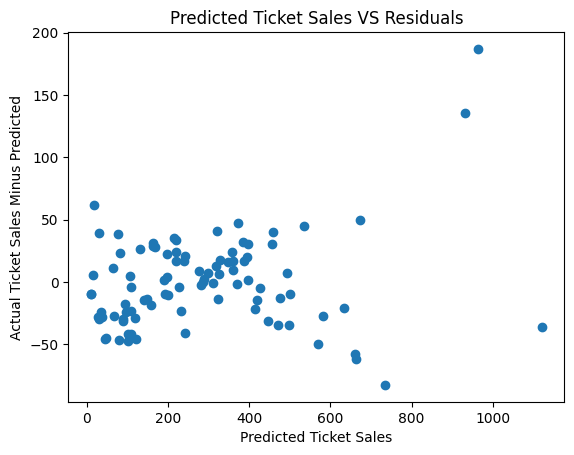

In [19]:
pred_Y_test = model.predict(test_X)
test_rmse = RMSE(test_Y, pred_Y_test)
print(f'The test set rmse is {test_rmse} and our residual plot looks like this: ')
plt.scatter(x = pred_Y_test, y = (test_Y - pred_Y_test))
plt.xlabel('Predicted Ticket Sales')
plt.ylabel('Actual Ticket Sales Minus Predicted')
plt.title('Predicted Ticket Sales VS Residuals');
